In [ ]:
pip install -r requirements-inv.txt

In [1]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Machine learning models and preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous utilities
import time

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the cleaned DataFrame from the CSV file
df_pca_combined = pd.read_csv('df_pca_combined.csv')

# Utility Functions

In [2]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

# Linear Regression

{'Dataset': 'Linear Regression (Training)', 'MSE': 0.0393443536224872, 'RMSE': 0.1983541116853573, 'MAE': 0.14248144407599142, 'MAPE': 64.80897942368159, 'R²': 0.9603542429526544, 'Adjusted R²': 0.9598089958311358, 'Training Time': 0.025028228759765625}
{'Dataset': 'Linear Regression (Validation)', 'MSE': 0.039218996109519476, 'RMSE': 0.19803786534276588, 'MAE': 0.13961857865248875, 'MAPE': 56.015550896328435, 'R²': 0.9610580234334447, 'Adjusted R²': 0.9594049762649052, 'Training Time': None}
{'Dataset': 'Linear Regression (Test)', 'MSE': 0.03818788393935661, 'RMSE': 0.19541720481921906, 'MAE': 0.14231529579329202, 'MAPE': 71.07182224575067, 'R²': 0.962712427890116, 'Adjusted R²': 0.9611308995461405, 'Training Time': None}

Additional Metrics (Not Included in Inter-Model Comparison):
Cross-Validation RMSE: 0.20251953631918515
Explained Variance: 0.9627167341025583
Durbin-Watson Stat: 2.0390814633247296
Breusch-Pagan p-value (Heteroscedasticity): 1.3455391323866635e-33


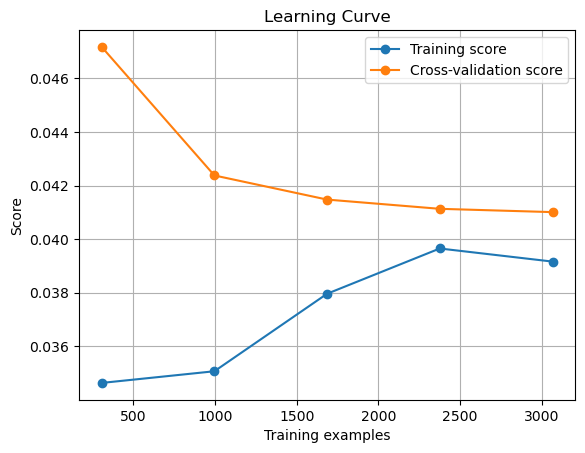

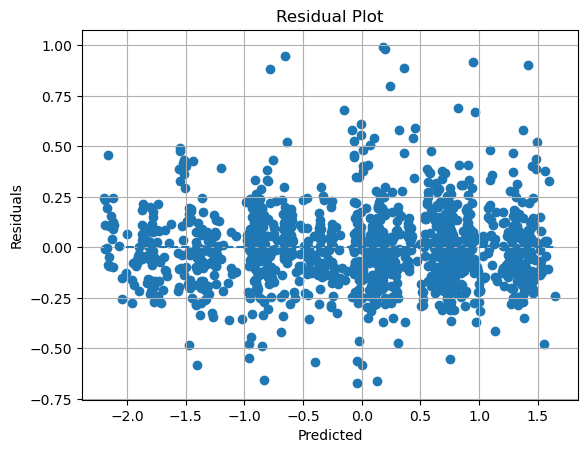

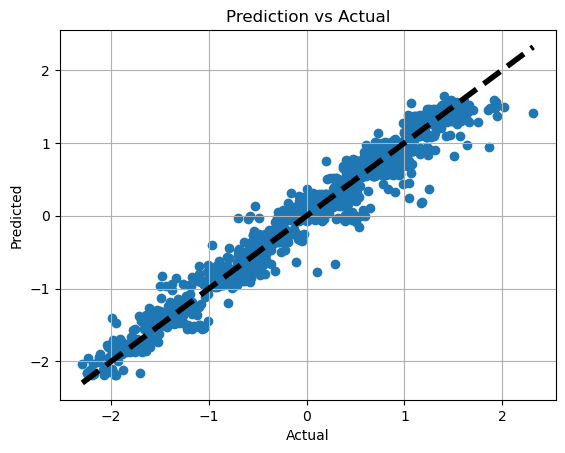

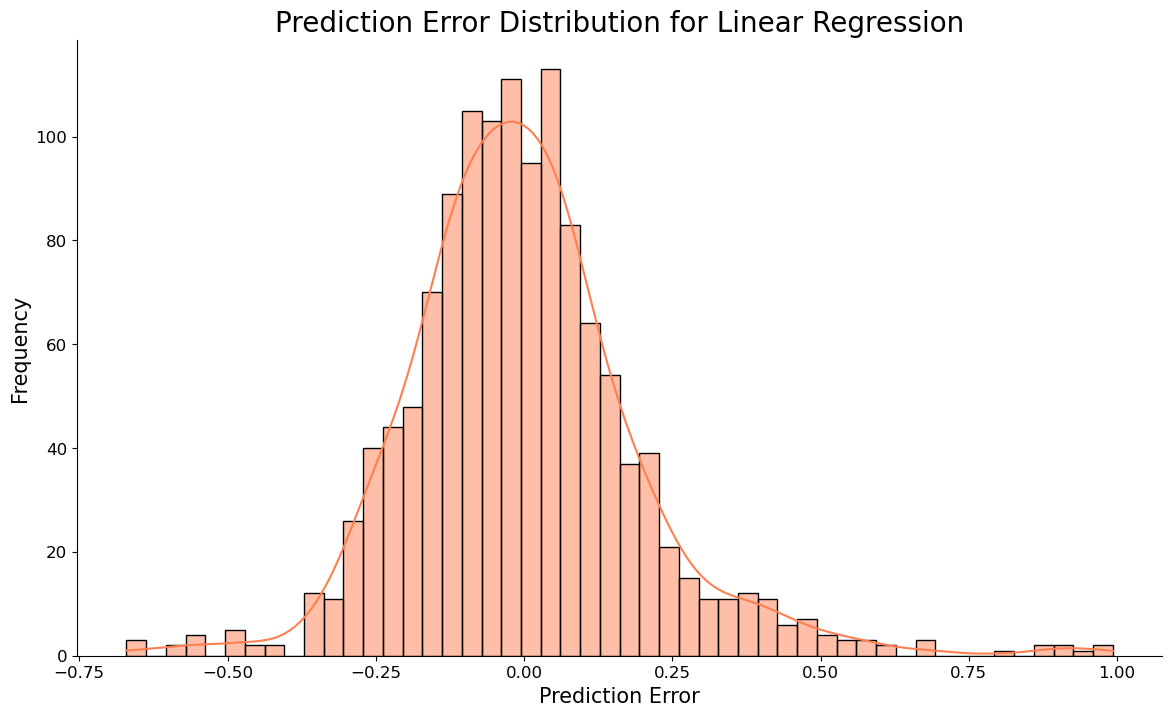

In [7]:
# Import necessary libraries for pre-inter-model comparison
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Define the function to run the Linear Regression model with separated metrics
def run_linear_regression(df_pca_combined, target_column='Weekly_Sales', results_filename='linear_regression_results.csv'):
    df_linreg = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_linreg, target_column)
    model = LinearRegression()
    
    # Record the start time for training
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluate model (Inter-model comparison metrics)
    lr_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Linear Regression (Training)')
    lr_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Linear Regression (Validation)')
    lr_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Linear Regression (Test)')

    # Cross-Validation (k=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())  # Take the mean and convert to RMSE

    # Explained Variance Score
    explained_var = explained_variance_score(y_test, y_test_pred)
    
    # Residual Analysis: Durbin-Watson Test for Autocorrelation
    residuals = y_test - y_test_pred
    dw_stat = durbin_watson(residuals)
    
    # Heteroscedasticity: Breusch-Pagan Test
    X_test_sm = sm.add_constant(X_test)  # Add constant for the test
    _, bp_pval, _, _ = het_breuschpagan(residuals, X_test_sm)

    # Create results list only for inter-model comparison metrics
    results = [
        {**lr_train_metrics, 'Training Time': training_time},
        lr_val_metrics,
        lr_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    # Print inter-model comparison results
    for result in results:
        print(result)

    # Print additional metrics separately (not included in results list)
    print("\nAdditional Metrics (Not Included in Inter-Model Comparison):")
    print(f"Cross-Validation RMSE: {cv_rmse}")
    print(f"Explained Variance: {explained_var}")
    print(f"Durbin-Watson Stat: {dw_stat}")
    print(f"Breusch-Pagan p-value (Heteroscedasticity): {bp_pval}")

    # Plot learning curve
    plot_learning_curve(model, X_train, y_train)
    
    # Plot residuals to check if errors are normally distributed
    plot_residuals(y_test, y_test_pred)
    
    # Plot predicted vs actual values
    plot_prediction_vs_actual(y_test, y_test_pred)

    # Perform error analysis
    error_analysis(y_test, y_test_pred, 'Linear Regression')

run_linear_regression(df_pca_combined)